# Investigatin Items and their impact on my League of Legends Games

This code is used in my blog post here: http://jeremywalsh.ca/2021/05/08/regression-analysis-for-items-and-gold-in-league-of-legends.html

In [1]:
!pip install riotwatcher
# !pip install ft2font
# !conda install matplotlib

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import requests

## Getting API Key

In [3]:
import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)

import sys,os
file_path = os.path.join(sys.path[0], ".secret/riotapi.json")

keys = get_keys(file_path)
API_Key = keys['API_Key']

## Getting Champion Data

In [4]:
from riotwatcher import LolWatcher, ApiError

lol_watcher = LolWatcher(API_Key)
my_region = 'na1'
me = lol_watcher.summoner.by_name(my_region, 'thereiswald0')

In [5]:
# First we get the latest version of the game from data dragon
versions = lol_watcher.data_dragon.versions_for_region(my_region)
champions_version = versions['n']['champion']

# Lets get some champions
current_champ_list = lol_watcher.data_dragon.champions(champions_version)
# print(current_champ_list)

# Item Analysis

In [6]:
# check league's latest version
latest = lol_watcher.data_dragon.versions_for_region(my_region)['n']['champion']
static_item_list = lol_watcher.data_dragon.items(latest, 'en_US')

In [7]:
item_id_keys = static_item_list['data'].keys()
item_ids = []
item_names = []
item_gold_list = []
item_stat_list = []
item_df = pd.DataFrame()
for item_id in item_id_keys:
    item_ids.append(item_id)
    item_names.append(static_item_list['data'][item_id]['name'])
    item_gold_list.append(static_item_list['data'][item_id]['gold']['total'])
    item_stat_list.append(static_item_list['data'][item_id]['stats'])
item_df = pd.DataFrame({'Item Name': item_names, 'Item Gold': item_gold_list, 'Item Stats': item_stat_list}, index=item_ids)
item_df.head()

,Item Name,Item Gold,Item Stats
1001,Boots,300,{'FlatMovementSpeedMod': 25}
1004,Faerie Charm,250,{}
1006,Rejuvenation Bead,150,{}
1011,Giant's Belt,900,{'FlatHPPoolMod': 350}
1018,Cloak of Agility,600,{'FlatCritChanceMod': 0.15}


Investigating Items

In [8]:
item_df[item_df['Item Name']=="Executioner's Calling"]

,Item Name,Item Gold,Item Stats
3123,Executioner's Calling,800,{'FlatPhysicalDamageMod': 15}


In [9]:
item_df[item_df['Item Name']=="Knight's Vow"]

,Item Name,Item Gold,Item Stats
3109,Knight's Vow,2300,{'FlatHPPoolMod': 400}


In [10]:
item_df[item_df['Item Name']=="Abyssal Mask"]

,Item Name,Item Gold,Item Stats
3001,Abyssal Mask,2700,"{'FlatHPPoolMod': 350, 'FlatSpellBlockMod': 60}"


In [11]:
item_df[item_df['Item Name']=='Ruby Crystal']

,Item Name,Item Gold,Item Stats
1028,Ruby Crystal,400,{'FlatHPPoolMod': 150}


In [12]:
ruby_hp = item_df['Item Stats'][item_df['Item Name']=='Ruby Crystal'][0]['FlatHPPoolMod']

In [13]:
champ_stats = pd.read_csv('champ_stats.csv', index_col=0)

## Pie Plots of Item Impact

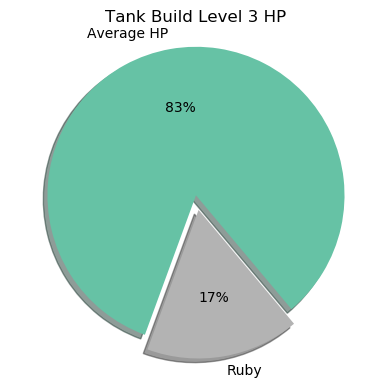

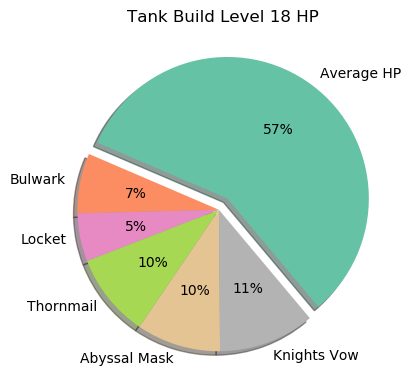

In [121]:
def pie_plot(value_list, label_list, title):

    cmap = plt.cm.Set2
    colors = cmap(np.linspace(0., 1., len(value_list)))
    
    my_explode = [0.1] + [0]*(len(value_list)-1)
    fig = plt.figure(figsize=(4,4))
    plt.pie(value_list, labels=label_list, autopct='%1.f%%', startangle=310, colors=colors, shadow = True, explode=my_explode)
    plt.title(title)
    plt.rcParams.update(plt.rcParamsDefault)
    plt.tight_layout() # so the labels aren't cutoff
    plt.axis('equal')
    plt.savefig('Plots/' + title)
    plt.show()

tank_stats = champ_stats[champ_stats['tags'].str.contains('Tank', case=True)]
tank_hp_list = [(tank_stats['hp'].mean()+tank_stats['hpperlevel']*2).mean(), ruby_hp]
my_labels = ['Average HP', 'Ruby']  
pie_plot(tank_hp_list, my_labels, 'Tank Build Level 3 HP')

tank_build_hp_dict = {'Bulwark': 250, 'Locket':200, 'Thornmail': 350, 'Abyssal Mask': 350, 'Knights Vow': 400}
tank_hp_list = [(tank_stats['hp']+tank_stats['hpperlevel']*17).mean()] + list(tank_build_hp_dict.values())
tank_hp_labels = ['Average HP'] + list(tank_build_hp_dict.keys())
pie_plot(tank_hp_list, tank_hp_labels, 'Tank Build Level 18 HP')

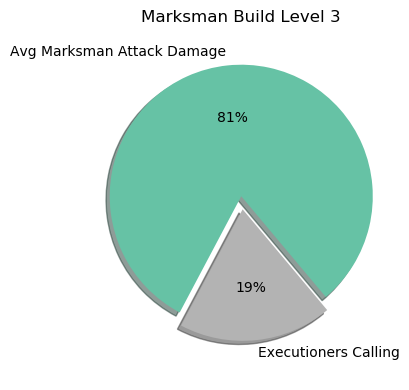

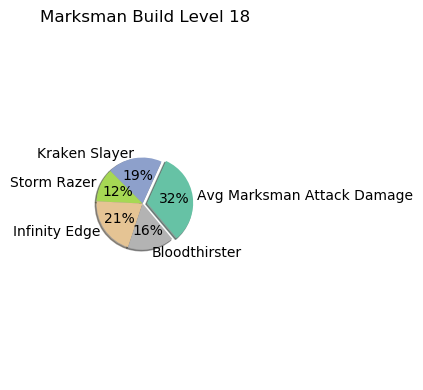

In [124]:
marksman_stats = champ_stats[champ_stats['tags'].str.contains('Marksman', case=True)]

#level 3
executioners_calling = 15
adc_ad_list = [(marksman_stats['attackdamage']+marksman_stats['attackdamageperlevel']*2).mean()] + [executioners_calling]
adc_ad_labels = ['Avg Marksman Attack Damage'] + ['Executioners Calling']
pie_plot(adc_ad_list, adc_ad_labels, 'Marksman Build Level 3')

#level 18
adc_build_ad_dict = {'Kraken Slayer': 65, 'Storm Razer':40, 'Infinity Edge': 70, 'Bloodthirster': 55}
adc_ad_list = [(marksman_stats['attackdamage']+marksman_stats['attackdamageperlevel']*17).mean()] + list(adc_build_ad_dict.values())
adc_ad_labels = ['Avg Marksman Attack Damage'] + list(adc_build_ad_dict.keys())
pie_plot(adc_ad_list, adc_ad_labels, 'Marksman Build Level 18')

# Regression Analysis

In [125]:
# Match detail
def get_match_detail(match, my_matches):
    last_match = my_matches['matches'][match]
    match_detail = lol_watcher.match.by_id(my_region, last_match['gameId'])
    return match_detail

## Pulling in Data from my games

In [17]:
my_matches = lol_watcher.match.matchlist_by_account(my_region, me['accountId'])
dfs = []

champions = {}
for champ in current_champ_list['data']:
    champions[f"{current_champ_list['data'][champ]['key']}"] = champ.lower().replace(' ', '')
              
classic_matches = (match for match in range(len(my_matches['matches'])) if get_match_detail(match, my_matches)['gameMode']=='CLASSIC')
for match in classic_matches:
# for match in range(len(my_matches['matches'])):
    match_detail = get_match_detail(match, my_matches)
    # fetch last match detail
    last_match = my_matches['matches'][match]
    match_detail = lol_watcher.match.by_id(my_region, last_match['gameId'])

    participants = []
    for row_num, row in enumerate(match_detail['participants']):
        participants_row = {}
        participants_row['PlayerID'] = row['participantId']
        participants_row['PlayerName'] = match_detail['participantIdentities'][row_num]['player']['summonerName']
        participants_row['ChampionId'] = row['championId']
        participants_row['Spell1'] = row['spell1Id']
        participants_row['Spell2'] = row['spell2Id']
        participants_row['Win'] = row['stats']['win']
        participants_row['Kills'] = row['stats']['kills']
        participants_row['Deaths'] = row['stats']['deaths']
        participants_row['Assists'] = row['stats']['assists']
        participants_row['TotalDamageDealt'] = row['stats']['totalDamageDealt']
        participants_row['GoldEarned'] = row['stats']['goldEarned']
        participants_row['GoldSpent'] = row['stats']['goldSpent']
        participants_row['ChampLevel'] = row['stats']['champLevel']
        participants_row['TotalMinionsKilled'] = row['stats']['totalMinionsKilled']
        participants_row['LongestTimeSpentLiving'] = row['stats']['longestTimeSpentLiving']
        
        # Get each of the timeline stats 
        time_list = row['timeline']['creepsPerMinDeltas'].keys()
        for time in time_list:
            participants_row['Cspermin' + str(time)] = row['timeline']['creepsPerMinDeltas'][str(time)]
            participants_row['Xppermin' + str(time)] = row['timeline']['xpPerMinDeltas'][str(time)]
            participants_row['Goldpermin' + str(time)] = row['timeline']['goldPerMinDeltas'][str(time)]
            participants_row['Damagepermin' + str(time)] = row['timeline']['damageTakenPerMinDeltas'][str(time)]
        participants_row['Role'] = row['timeline']['role']
        participants_row['Lane'] = row['timeline']['lane']
        participants.append(participants_row)
    df = pd.DataFrame(participants)
    # Convert champion id to a readable name
    df['Champion Name'] = df['ChampionId'].astype(str).map(champions)
    df['Game Duration'] = match_detail['gameDuration']
    df['Game ID'] = match_detail['gameId']
    dfs.append(df)

In [18]:
df = pd.concat(dfs)
prediction_features = ['Kills', 'Deaths', 'GoldEarned', 'TotalDamageDealt', 'TotalMinionsKilled']
for y_name in prediction_features:
    df[y_name + 'per Minute'] = df[y_name]/(df['Game Duration']/60)

/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [22]:
df.columns

Index(['Assists', 'ChampLevel', 'Champion Name', 'ChampionId', 'Cspermin0-10',
       'Cspermin10-20', 'Cspermin20-30', 'Cspermin30-end', 'Damagepermin0-10',
       'Damagepermin10-20', 'Damagepermin20-30', 'Damagepermin30-end',
       'Deaths', 'Game Duration', 'Game ID', 'GoldEarned', 'GoldSpent',
       'Goldpermin0-10', 'Goldpermin10-20', 'Goldpermin20-30',
       'Goldpermin30-end', 'Kills', 'Lane', 'LongestTimeSpentLiving',
       'PlayerID', 'PlayerName', 'Role', 'Spell1', 'Spell2',
       'TotalDamageDealt', 'TotalMinionsKilled', 'Win', 'Xppermin0-10',
       'Xppermin10-20', 'Xppermin20-30', 'Xppermin30-end', 'Killsper Minute',
       'Deathsper Minute', 'GoldEarnedper Minute',
       'TotalDamageDealtper Minute', 'TotalMinionsKilledper Minute'],
      dtype='object')

In [29]:
print('Number of games played: ' + str(len(df['Game ID'].unique())))

Number of games played: 32


## Regression

In [82]:
# Scikit Learn Imports for Regression Analysis
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

#for pvalue
import statsmodels.api as sm

In [116]:
def pred_vs_actual(X_test, y_test, y_name):
    y_pred = regr.predict(X_test)
    fig = plt.figure(figsize=(5,5))
    plt.scatter(y_pred, y_test)
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], c='r')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    title = y_name + ' Predicted vs Actual'
    plt.title(title)
    plt.tight_layout() # so the labels aren't cutoff
    plt.savefig('Plots/' + title)
    plt.show()

    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

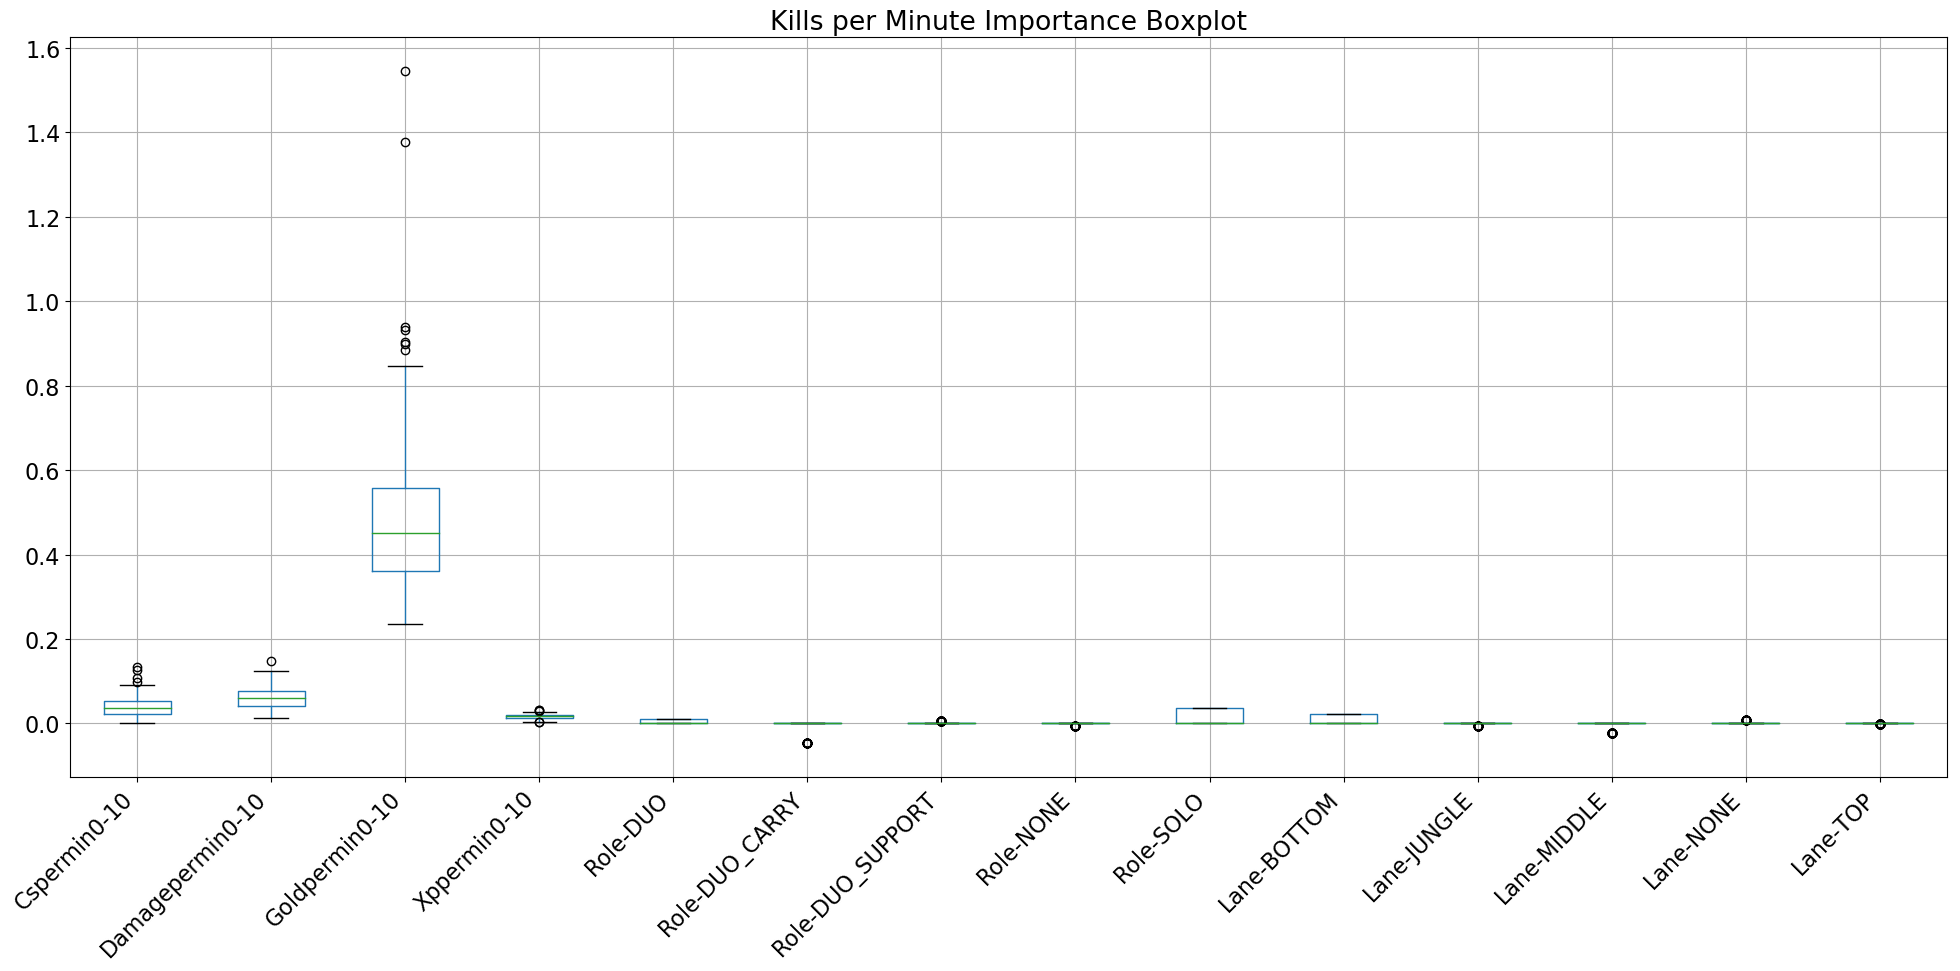

Kills per Minute Importance Boxplot
Train Score: 0.5941970637876731
Test Score: 0.45847046461009666
Intercept: -0.3952106177235065


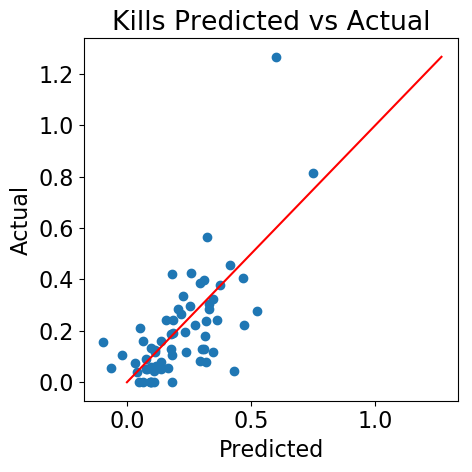

Root Mean Squared Error: 0.15
p values
Cspermin0-10        1.528985e-01
Damagepermin0-10    2.983631e-02
Goldpermin0-10      1.236439e-28
Xppermin0-10        7.453693e-01
Role-DUO            1.628581e-08
Role-DUO_CARRY      1.029210e-08
Role-DUO_SUPPORT    3.447741e-10
Role-NONE           1.176345e-10
Role-SOLO           3.244415e-05
Lane-BOTTOM         1.478422e-10
Lane-JUNGLE         1.176345e-10
Lane-MIDDLE         1.118205e-09
Lane-NONE           1.228376e-04
Lane-TOP            7.942159e-11
dtype: float64


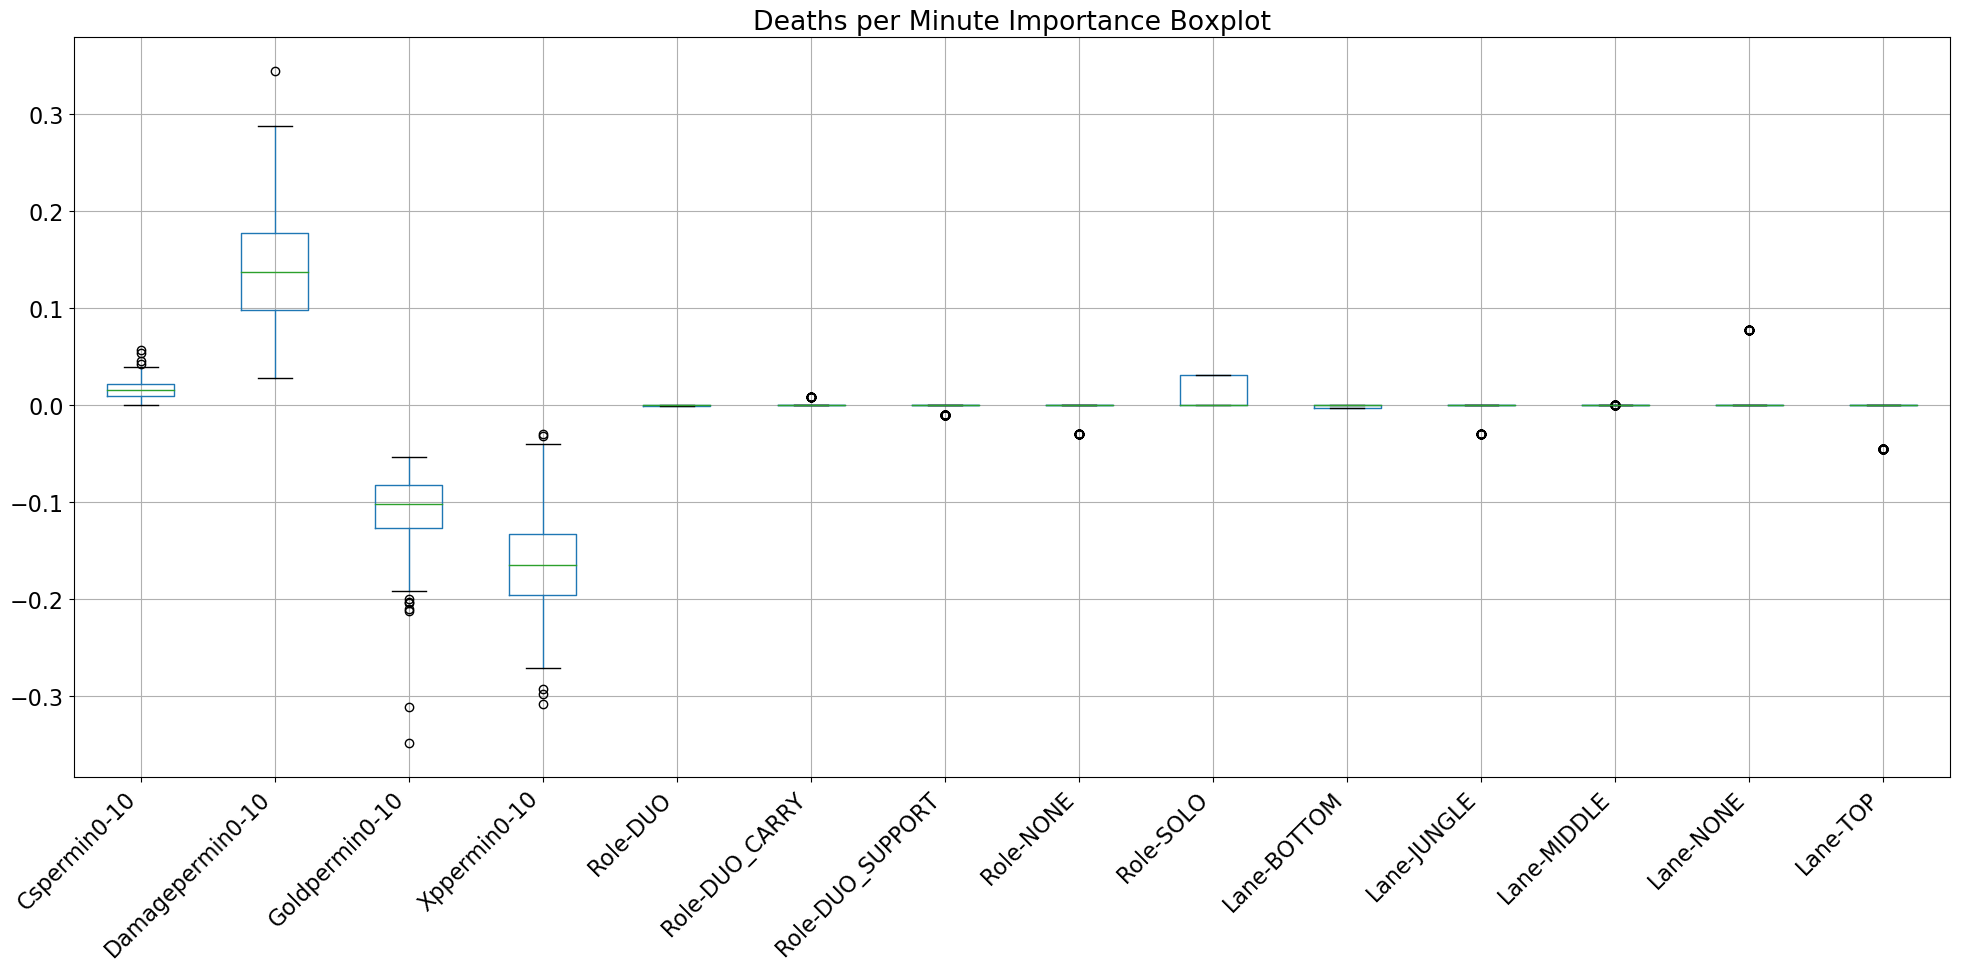

Deaths per Minute Importance Boxplot
Train Score: 0.39289630774755235
Test Score: 0.3030063020272591
Intercept: 0.3323383693409326


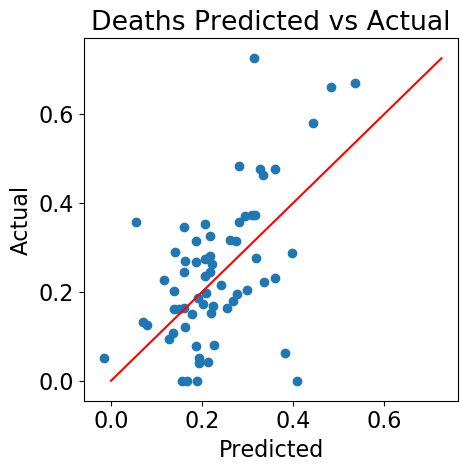

Root Mean Squared Error: 0.14
p values
Cspermin0-10        4.072674e-01
Damagepermin0-10    6.348028e-11
Goldpermin0-10      1.401371e-04
Xppermin0-10        3.529814e-05
Role-DUO            2.367615e-11
Role-DUO_CARRY      3.294967e-08
Role-DUO_SUPPORT    5.928847e-12
Role-NONE           3.566867e-09
Role-SOLO           2.378862e-11
Lane-BOTTOM         2.852974e-15
Lane-JUNGLE         3.566867e-09
Lane-MIDDLE         5.607430e-10
Lane-NONE           8.720605e-11
Lane-TOP            6.647294e-08
dtype: float64


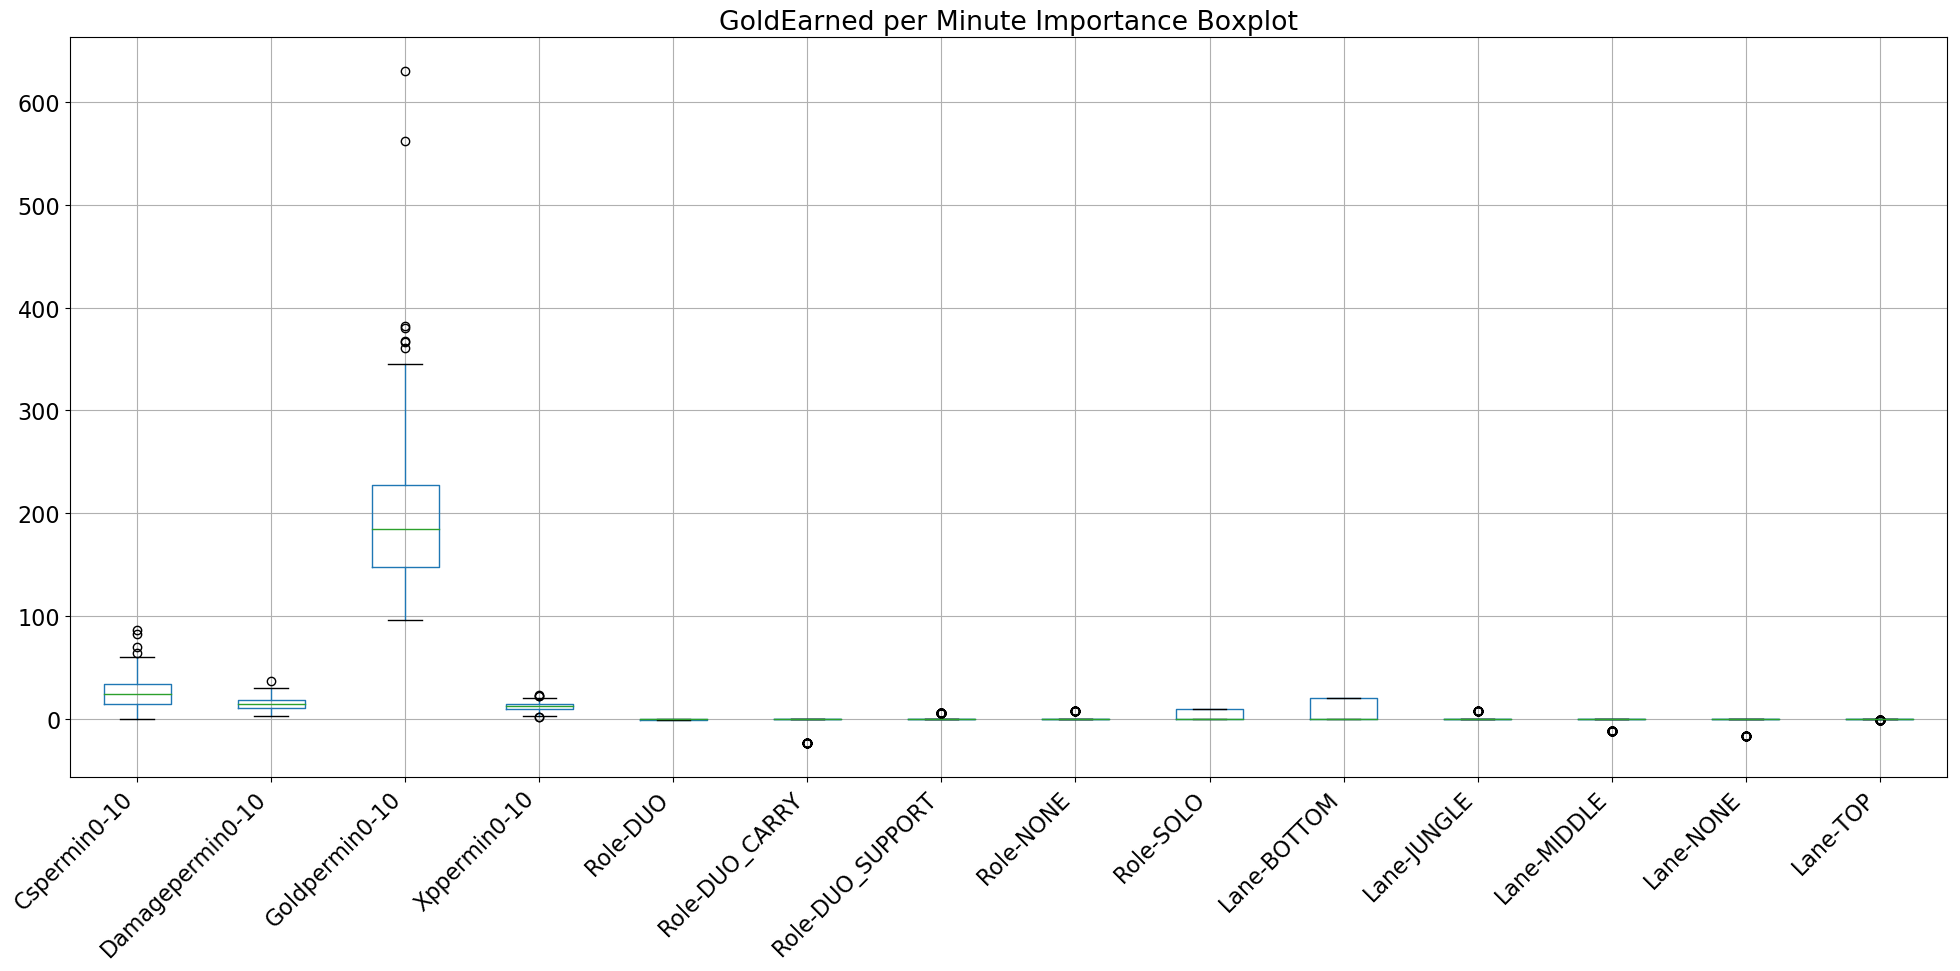

GoldEarned per Minute Importance Boxplot
Train Score: 0.608089005556761
Test Score: 0.4927794091013915
Intercept: 56.83184777224881


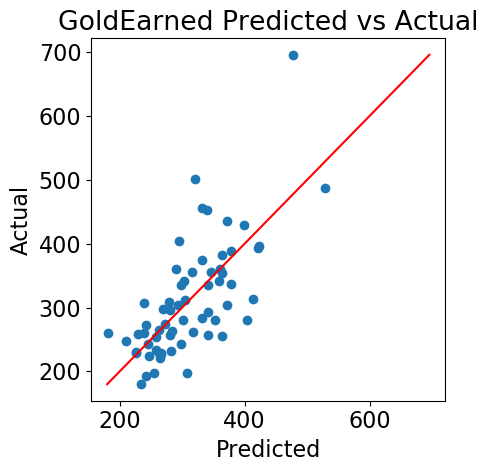

Root Mean Squared Error: 63.2
p values
Cspermin0-10        2.460313e-02
Damagepermin0-10    1.955029e-01
Goldpermin0-10      5.514632e-28
Xppermin0-10        5.640701e-01
Role-DUO            3.712000e-02
Role-DUO_CARRY      7.802996e-01
Role-DUO_SUPPORT    4.446260e-03
Role-NONE           3.810110e-03
Role-SOLO           1.608584e-02
Lane-BOTTOM         9.418096e-06
Lane-JUNGLE         3.810110e-03
Lane-MIDDLE         2.330414e-01
Lane-NONE           5.659504e-01
Lane-TOP            2.320159e-02
dtype: float64


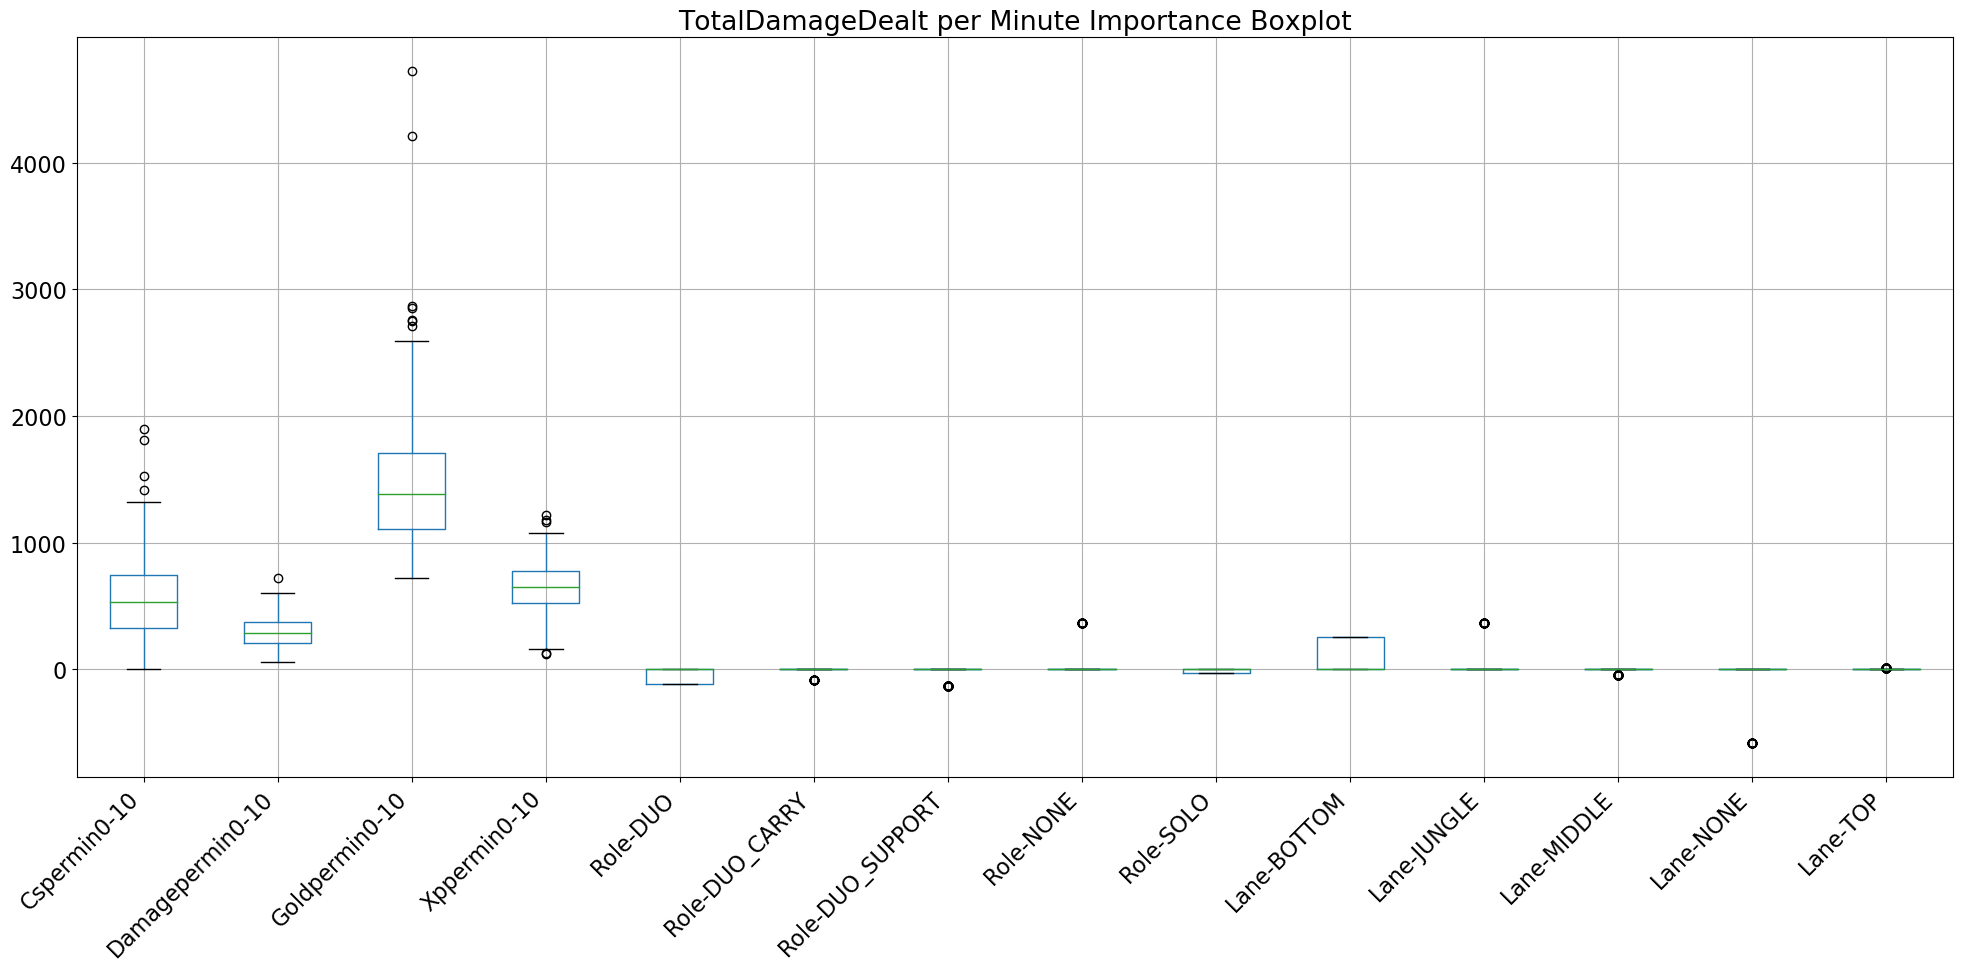

TotalDamageDealt per Minute Importance Boxplot
Train Score: 0.47367870371630044
Test Score: 0.21649080345039706
Intercept: -270.3880234202379


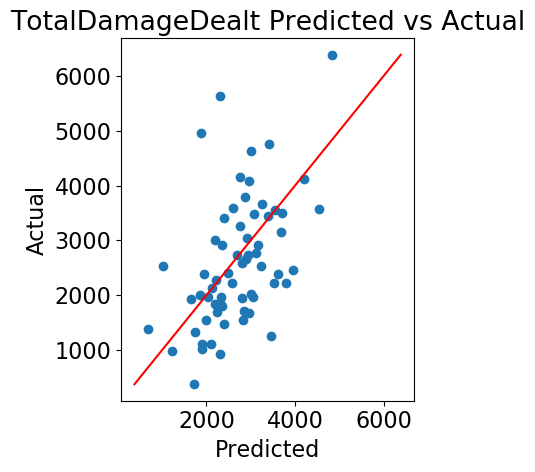

Root Mean Squared Error: 1039.22
p values
Cspermin0-10        9.633073e-04
Damagepermin0-10    8.735867e-02
Goldpermin0-10      1.293660e-09
Xppermin0-10        4.555512e-02
Role-DUO            1.966479e-01
Role-DUO_CARRY      3.787435e-01
Role-DUO_SUPPORT    1.384391e-01
Role-NONE           2.095371e-01
Role-SOLO           4.846124e-01
Lane-BOTTOM         4.613388e-01
Lane-JUNGLE         2.095371e-01
Lane-MIDDLE         3.925982e-01
Lane-NONE           1.637818e-02
Lane-TOP            4.942644e-01
dtype: float64


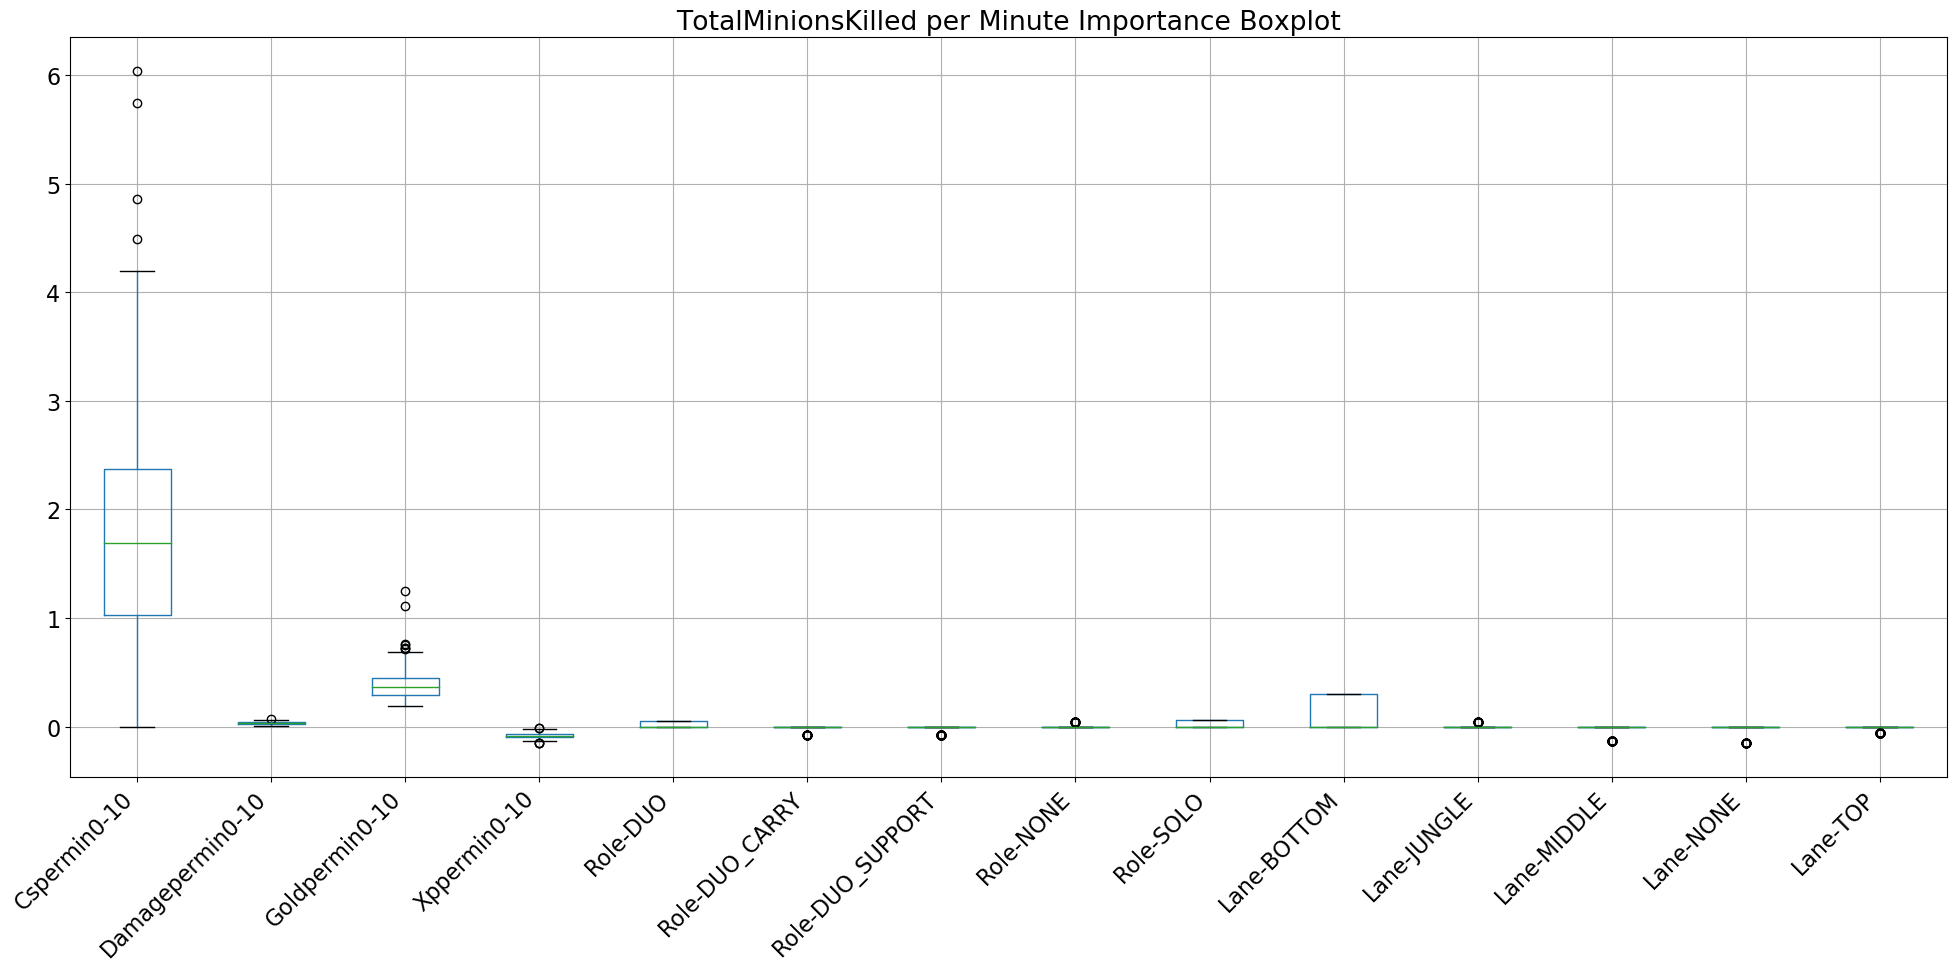

TotalMinionsKilled per Minute Importance Boxplot
Train Score: 0.7380600742711001
Test Score: 0.6279531326517365
Intercept: 0.45488556066894725


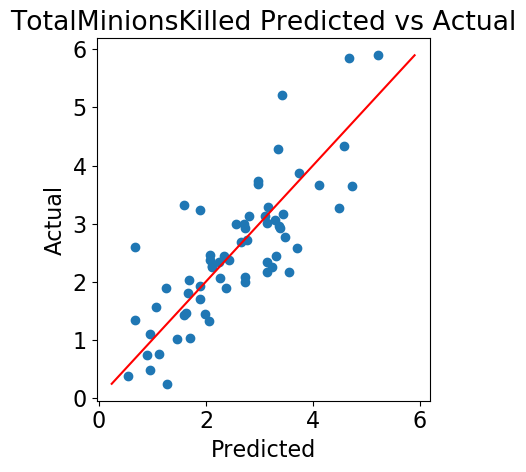

Root Mean Squared Error: 0.71
p values
Cspermin0-10        2.708393e-37
Damagepermin0-10    8.028268e-01
Goldpermin0-10      1.770266e-02
Xppermin0-10        7.134889e-01
Role-DUO            4.333913e-02
Role-DUO_CARRY      3.915852e-01
Role-DUO_SUPPORT    2.444870e-01
Role-NONE           3.751916e-02
Role-SOLO           7.650828e-02
Lane-BOTTOM         5.274564e-06
Lane-JUNGLE         3.751916e-02
Lane-MIDDLE         5.267719e-01
Lane-NONE           7.007822e-01
Lane-TOP            1.771637e-01
dtype: float64


In [117]:
X = df[['Cspermin0-10', 'Damagepermin0-10', 'Goldpermin0-10', 'Xppermin0-10']]
role_df = pd.get_dummies(df['Role'], prefix='Role', prefix_sep= '-')
lane_df = pd.get_dummies(df['Lane'], prefix='Lane', prefix_sep= '-')
X = pd.concat([X, role_df], axis=1)
X = pd.concat([X, lane_df], axis=1)
X.reset_index(inplace=True, drop=True)

for y_name in prediction_features:
    y = df[y_name + 'per Minute']

    # Taking 20% for testing and holding the random state for reproducability
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    title = y_name + ' per Minute Importance Boxplot'
    plt.rcParams.update({'font.size': 16})
    X_train.multiply(regr.coef_, axis=1).boxplot(figsize=(20,10))
    
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout() # so the labels aren't cutoff
    plt.savefig('Plots/' + title)
    plt.show()

    print(title)
    print('Train Score: ' + str(regr.score(X_train, y_train)))
    print('Test Score: ' + str(regr.score(X_test, y_test)))
    print('Intercept: ' + str(regr.intercept_))
    
    pred_vs_actual(X_test, y_test, y_name)
    
    #to get pvalue
    X2 = sm.add_constant(X_train)
    est = sm.OLS(list(y_train), X_train)
    est2 = est.fit()
    print('p values')
    print(est2.pvalues)

## Correlation Plot

In [43]:
import seaborn as sns #for correlation heatmap plot

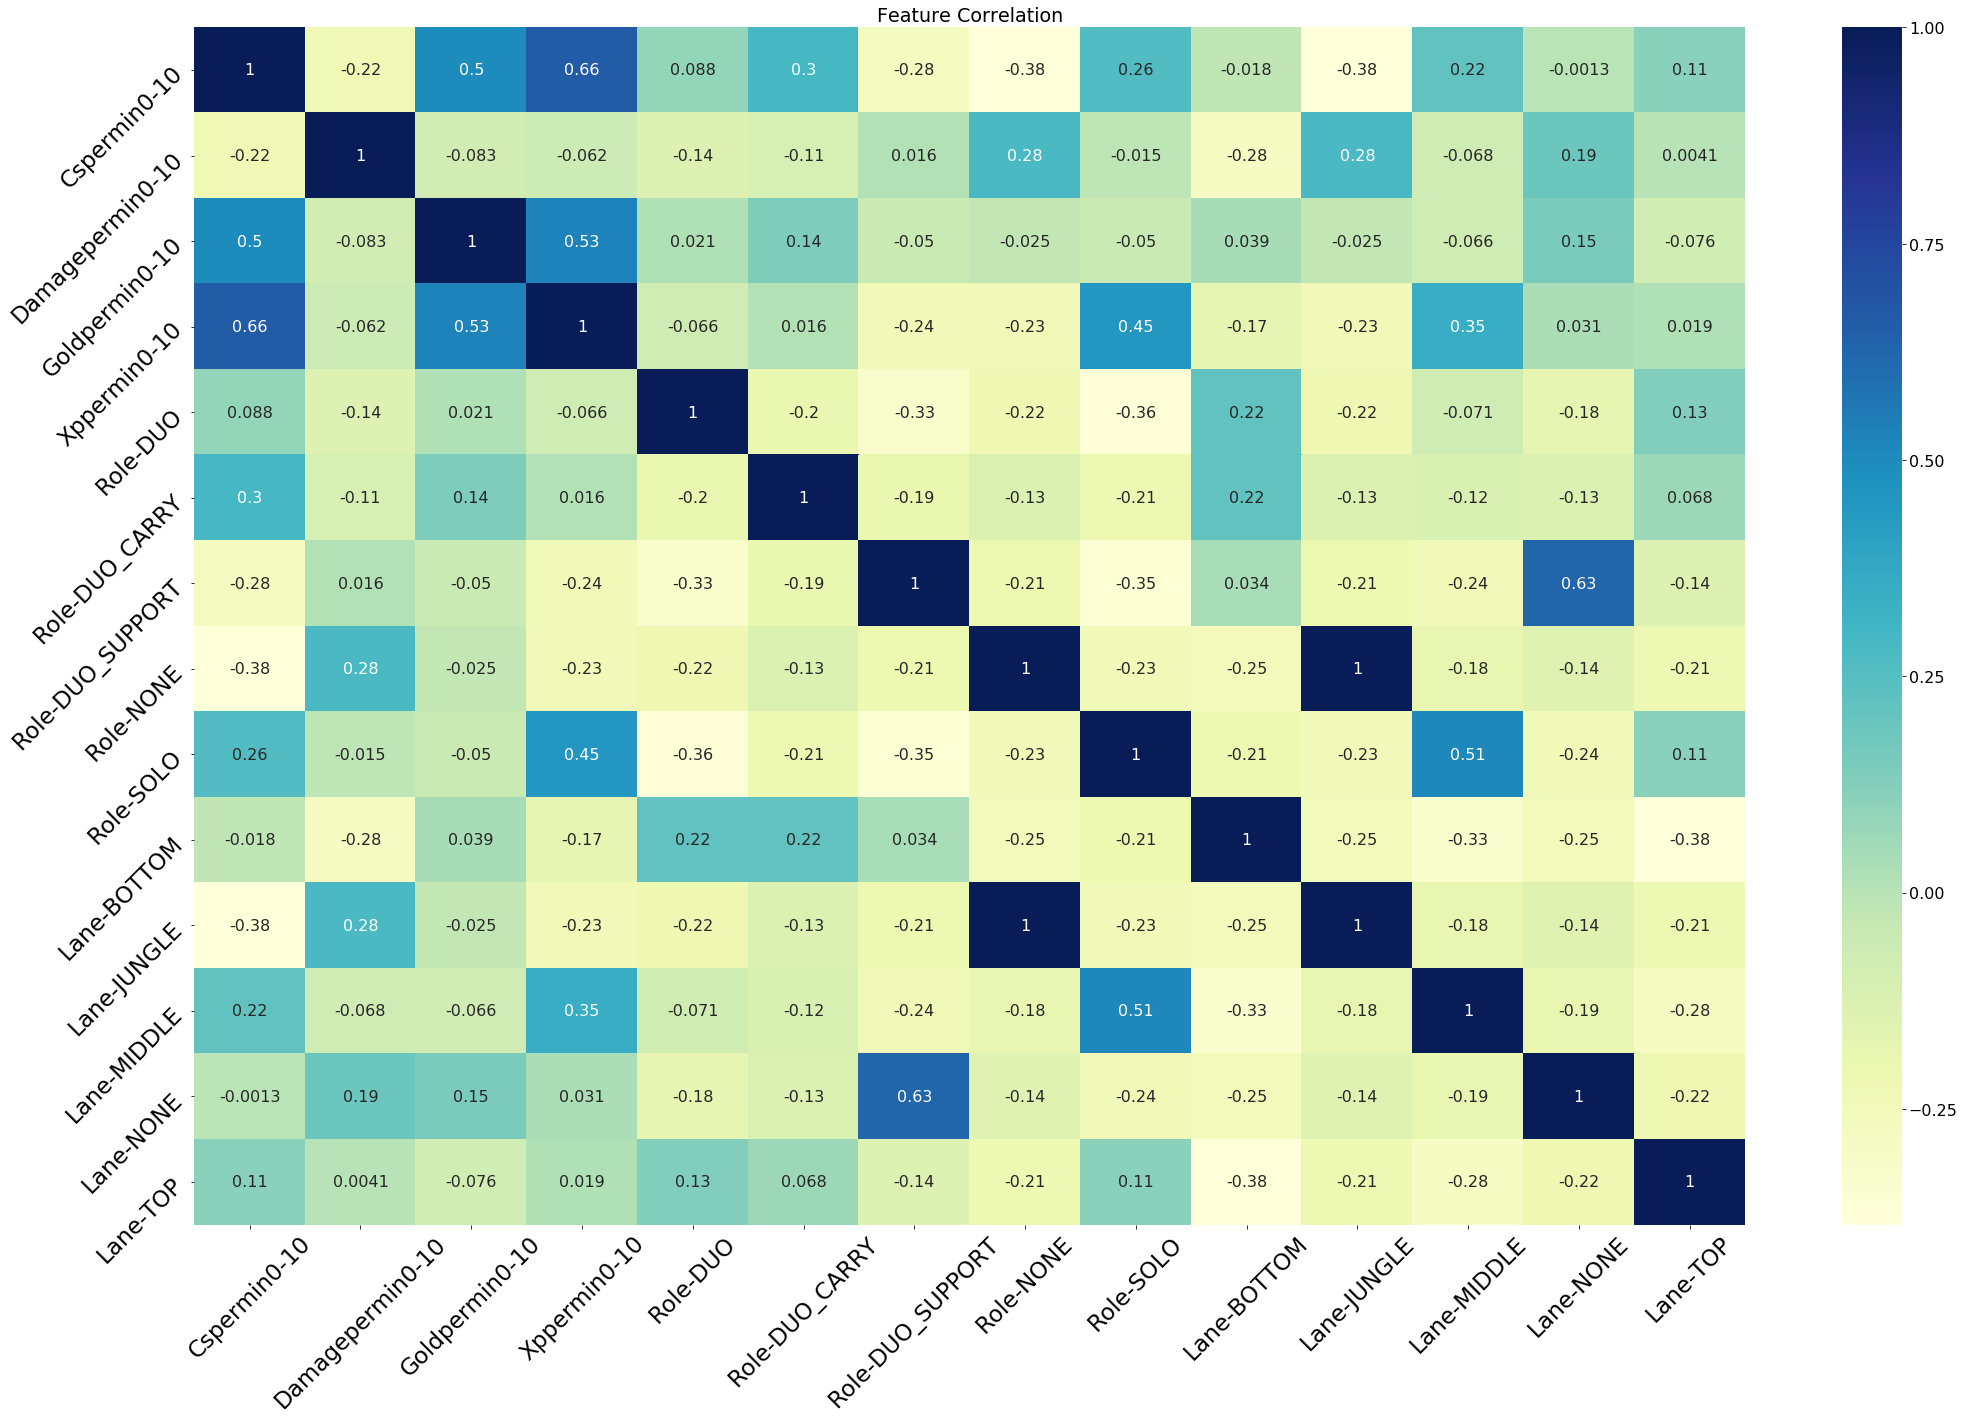

In [53]:
correlation = X.corr()
fig = plt.figure(figsize=(30,20))
sns.heatmap(correlation, cmap="YlGnBu", annot=True)
plt.yticks(rotation=45, size='x-large')
plt.xticks(rotation=45, size='x-large')
title = 'Feature Correlation'
plt.title(title)
plt.tight_layout() # so the labels aren't cutoff
plt.show()
fig.savefig('Plots/' + title)

## Regression Analysis with just cspermin, role and lane

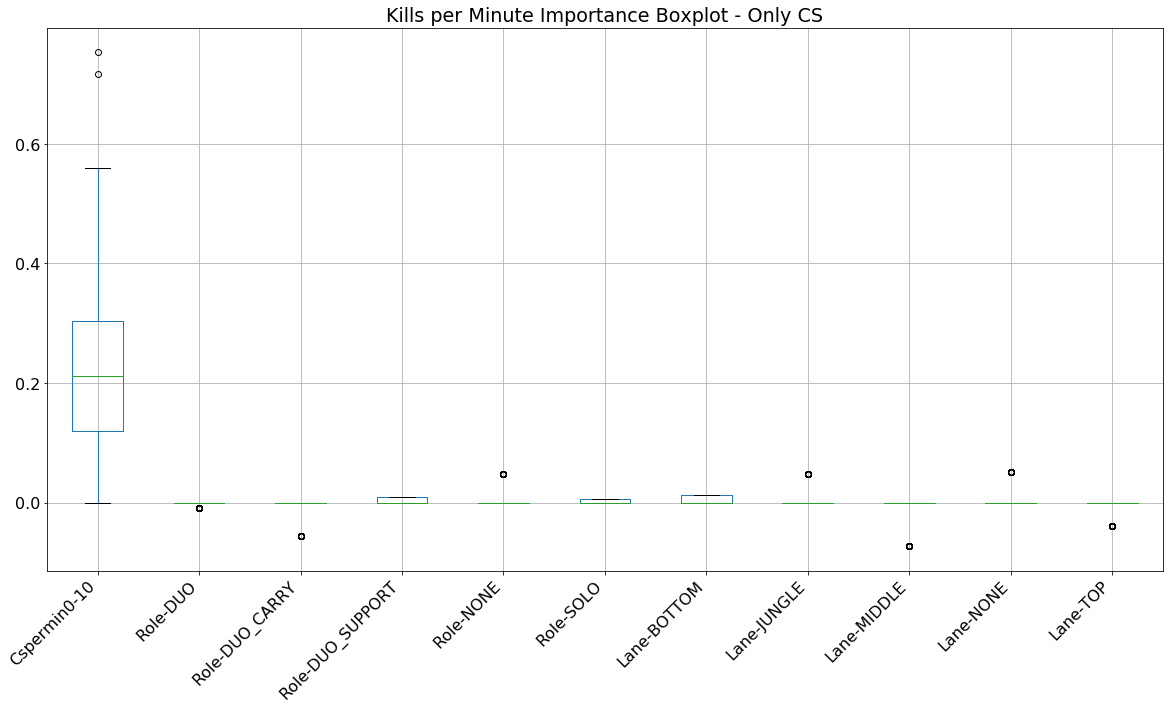

Kills per Minute Importance Boxplot - Only CS
0.2898515868202054
-0.10465582249408234


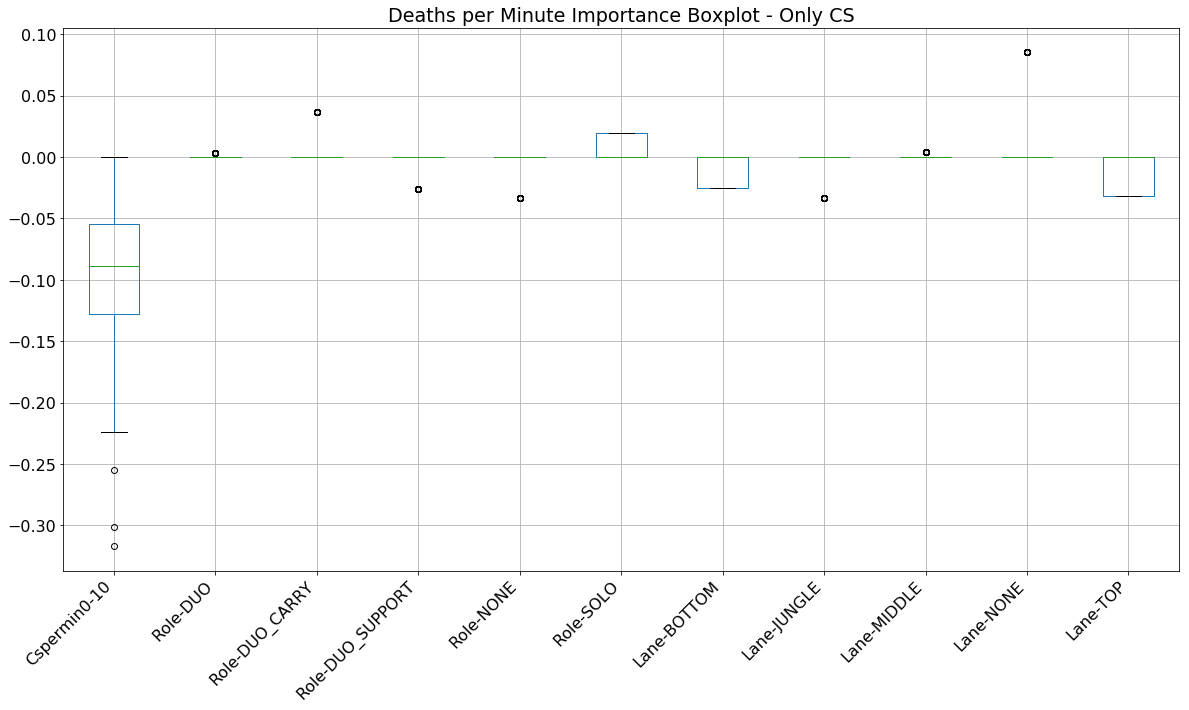

Deaths per Minute Importance Boxplot - Only CS
0.04292256012349216
0.3006414041441796


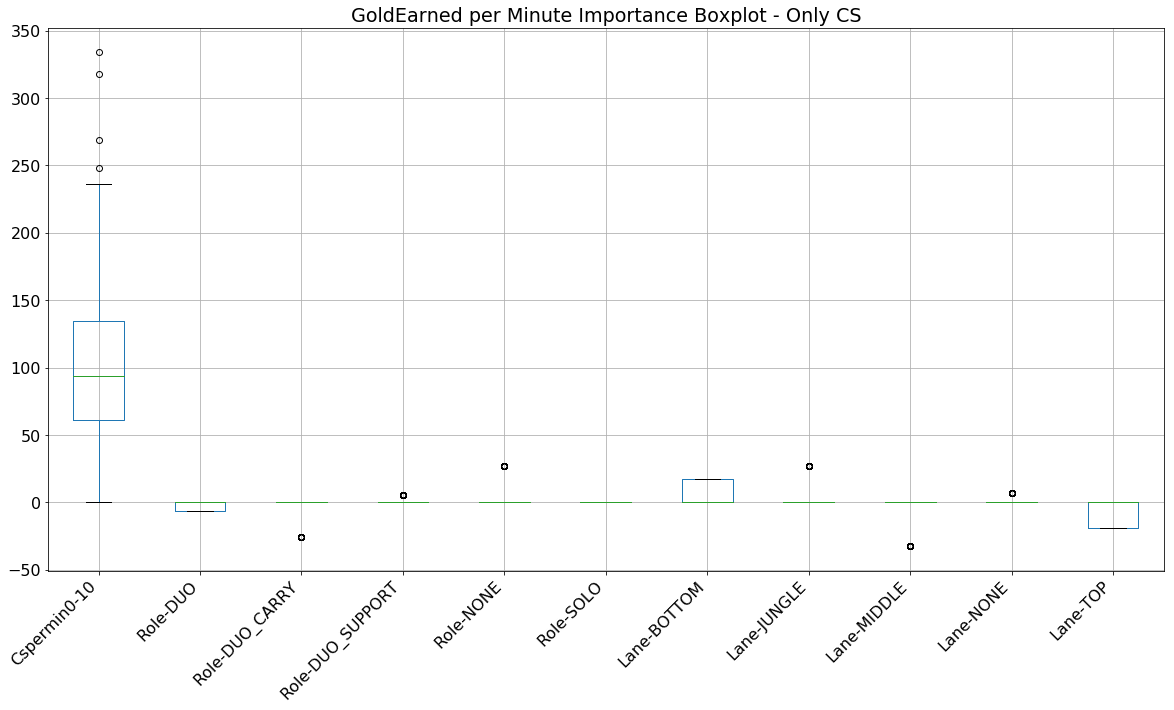

GoldEarned per Minute Importance Boxplot - Only CS
0.26771648440599305
0.22954655360128218


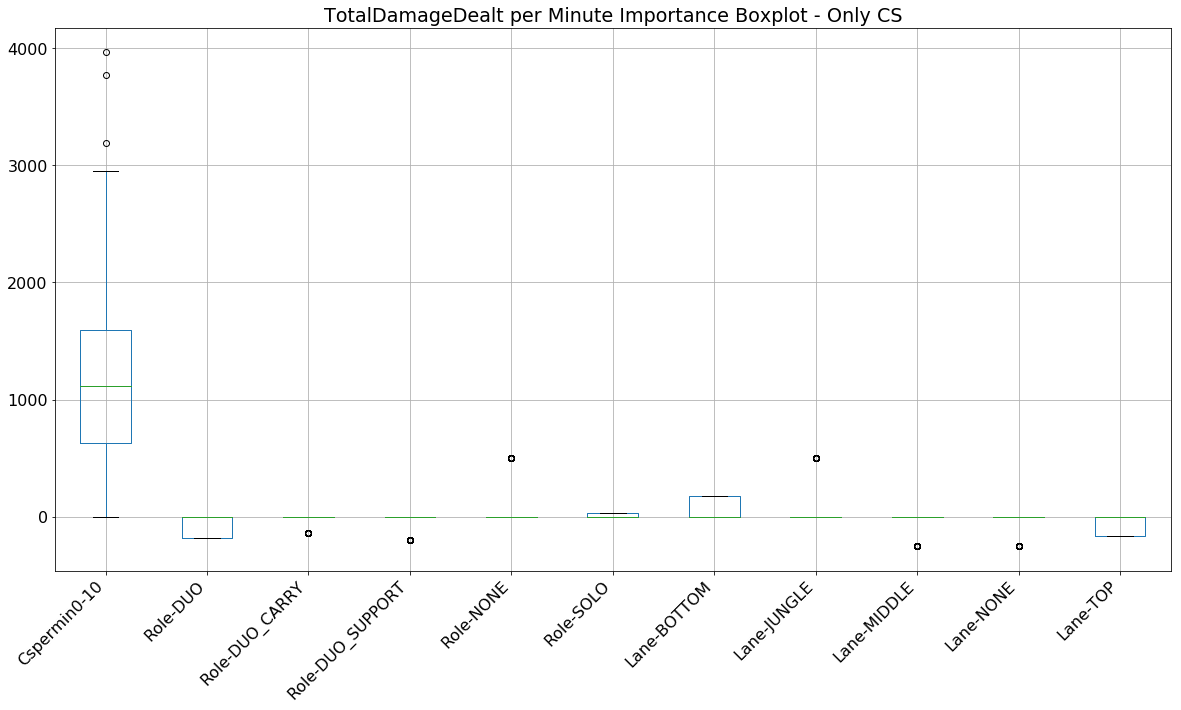

TotalDamageDealt per Minute Importance Boxplot - Only CS
0.3237377655389589
-0.012134290941830495


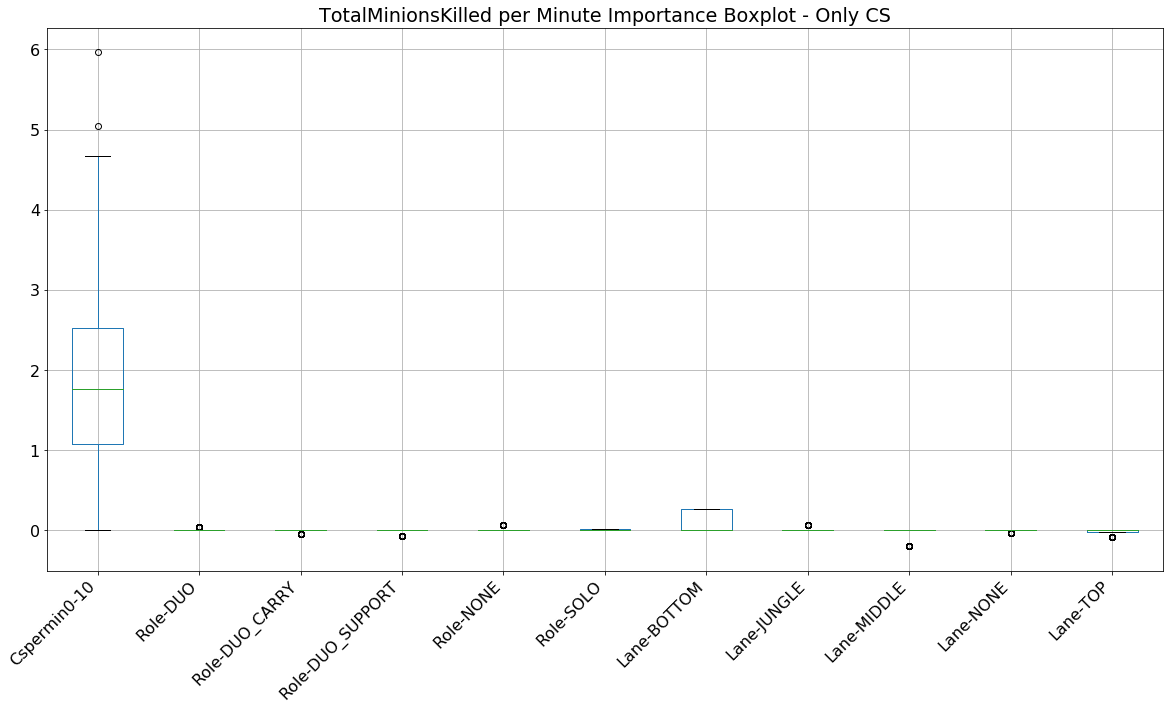

TotalMinionsKilled per Minute Importance Boxplot - Only CS
0.6996988604870191
0.7517238764086246


In [32]:
X = df[['Cspermin0-10']]
role_df = pd.get_dummies(df['Role'], prefix='Role', prefix_sep= '-')
lane_df = pd.get_dummies(df['Lane'], prefix='Lane', prefix_sep= '-')
X = pd.concat([X, role_df], axis=1)
X = pd.concat([X, lane_df], axis=1)
X.reset_index(inplace=True, drop=True)

for y_name in prediction_features:
    y = df[y_name + 'per Minute']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    title = y_name + ' per Minute Importance Boxplot - Only CS'
    plt.rcParams.update({'font.size': 16})
    X_train.multiply(regr.coef_, axis=1).boxplot(figsize=(20,10))
    
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout() # so the labels aren't cutoff
    plt.savefig('Plots/' + title)
    plt.show()

    print(title)
    print('Train Score: ' + str(regr.score(X_train, y_train)))
    print('Test Score: ' + str(regr.score(X_test, y_test)))
    print('Intercept: ' + str(regr.intercept_))

Dip in accuracy for most of the ys but the same trend we would expect exists

# Wrapup

For more information on items I'd recommend going here: https://leagueoflegends.fandom.com/wiki/Item_(League_of_Legends)

For a look at how early game gold affects winrate at the pro level check out this analysis:  https://oracleselixir.com/blog/post/10689/early-game-rating-2-0. 